# Evaluation of the transcripts generated with automatic speech recognition.

In this notebook, we try to compare manual transcripts with the transcripts automatically generated using vosk.

Those transcripts can be found in the [Transcripts](Transcripts/) folder. They are named after the person being interviewed. For each person, only the first 12 minutes of the audio record have been transcribed using vosk. So we have to take into account only the text corresponding to the first 12 minutes of audio in the manual transcripts. To do so, we search manually the last word being said after 12 minutes and take note of total number of caracters from the begining till the end of the last word. We then cut off the rest of the text in the `comparison()` function (see code below for more details).

Transcripts written manually:
- [alexis.docx](Transcripts/alexis.docx)
- [caitlyn.docx](Transcripts/caitlyn.docx)
- [clement1.docx](Transcripts/clement1.docx)
- [clement2.docx](Transcripts/clement2.docx)

Transcripts automatically generated with vosk:
- [vosk_alexis.txt](Transcripts/vosk_alexis.txt)
- [vosk_caitlyn.txt](Transcripts/vosk_caitlyn.txt)
- [vosk_clement1.txt](Transcripts/vosk_clement1.txt)
- [vosk_clement2.txt](Transcripts/vosk_clement2.txt)

When comparing two corresponding texts, the first thing we notice is that the vosk transcripts do not contain any punctuation, capital letters or paragraphs, whereas the human transcripts contains punctuation, some onomatopoeias which are not in the vosk transcripts (such as "humm"), and a special syntax with "#" at the beginning and at the end of some paragraphs to indicate that the interviewer is speaking. Another difference is that the numbers in are written in full letters in the vosk transcripts, and with digits in the human transcript. Of course, in addition to these differences there are some errors of transcription

Those differences complicate the comparison between the transcripts. The best thing to do would be to find a way to automatically add punctuation to the vosk transcripts. But this being quite hard to do, we decided to (automatically) remove the punctuation from the human transcript, remove the "#", the line breaks (marked as "\n"), as well as remove some onomatopeas ("humm") and convert digit numbers to written letters. All this is done in the `remove_punctuation()` function. We get simplified manual transcripts.

Once this is done, the simplified manual transcripts are considered as the ground truth and we compute the word error rate (`'wer'`) for the vosk transcripts in the `comparison()` function.

In [139]:
import jiwer
import docx
import jiwer
import num2words

# get_text() converts the manual transcript docx files to a python string.
def get_text(filename):
    doc = docx.Document(filename)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)  # type: str

def remove_punctuation(text):
    punctuations = ".,?!#:;°"  # punctuation marks to be removed
    clean_txt = ""
    for char in text:
        if char not in punctuations:
            clean_txt += char

    clean_txt = clean_txt.lower()  # Capital letters replaced with lower case
    clean_txt = clean_txt.replace("\xa0", "")  # Remove non-breaking spaces
    clean_txt = clean_txt.replace(" \n ", " ")  # Remove line breaks
    clean_txt = clean_txt.replace("\n", "")
    clean_txt = clean_txt.replace(" humm ", " ")  # Remove "humm"
    clean_txt = clean_txt.replace("’", "'")  # Apostrophes are different (’ vs ')

    # We check each word seperatly to see if it is a number written in digits.
    # If it is a digit number we replace it with the matching number in letters.
    for word in str.split(clean_txt):
        if word.isdigit():
            len_word = len(word)
            number_word = num2words.num2words(int(word), lang='fr')
            pos = clean_txt.find(word)
            clean_txt = clean_txt[:pos] + number_word + clean_txt[pos+len_word:]  

    # num2words doesn't write 21 correctly so we correct it.
    clean_txt = clean_txt.replace("vingt et un", "vingt-et-un")

    return clean_txt

# The names used to identify the 4 pairs of transcripts studied.
list_names = ["alexis", 
              "caitlyn",
              "clement1",
              "clement2"]

# Number of caracters in the manual transcripts corresponding to the first 12 min
# of audio. This has been determined manually.
stop_12_min = {"alexis": 12313, 
               "caitlyn" : 12033,
               "clement1" : 10786,
               "clement2" : 8753}

# We comptute the WER for a vosk transcript and other types of error mesures
# in the comparison() function using the jiwer library.
def comparison(name):
    path_to_transcript = "transcripts/" + str(name) + ".docx"
    text = get_text(path_to_transcript)  # manual transcription
    clean_text = remove_punctuation(text)  # simplified manual transcrition
    clean_text = clean_text[:stop_12_min[name]]  # first 12 minutes in transcript
    vosk_file = open('transcripts/vosk_' + name + '.txt','r')
    vosk_text = vosk_file.read()  # vosk transcription
    result = jiwer.compute_measures(clean_text, vosk_text)  # computes WER...
    return result

# We compute the errors mesures for all the 4 transcriptions.
error_mesures = {}
for name in list_names:
    error_mesures[name] = comparison(name)
    
error_mesures

{'alexis': {'wer': 0.36015006252605253,
  'mer': 0.35717238528317485,
  'wil': 0.5027477120564747,
  'wip': 0.4972522879435252,
  'hits': 1555,
  'substitutions': 452,
  'deletions': 392,
  'insertions': 20},
 'caitlyn': {'wer': 0.3766914011348756,
  'mer': 0.3673903788846318,
  'wil': 0.537274685032102,
  'wip': 0.4627253149678981,
  'hits': 1486,
  'substitutions': 539,
  'deletions': 266,
  'insertions': 58},
 'clement1': {'wer': 0.457033125300048,
  'mer': 0.4469483568075117,
  'wil': 0.6246789232756114,
  'wip': 0.3753210767243886,
  'hits': 1178,
  'substitutions': 550,
  'deletions': 355,
  'insertions': 47},
 'clement2': {'wer': 0.4313960455362493,
  'mer': 0.42328042328042326,
  'wil': 0.594222838202449,
  'wip': 0.405777161797551,
  'hits': 981,
  'substitutions': 408,
  'deletions': 280,
  'insertions': 32}}

We save the reults in a json file (see [error_mesures.json](Transcripts/error_mesures.json)):

In [124]:
import json

with open("error_mesures.json", "w") as outfile:  
    json.dump(error_mesures, outfile)

To better read the result we display it as a data frame.

In [125]:
import pandas as pd

pd.DataFrame(error_mesures).round(decimals=2)

,alexis,caitlyn,clement1,clement2
wer,0.36,0.38,0.46,0.43
mer,0.36,0.37,0.45,0.42
wil,0.50,0.54,0.62,0.59
wip,0.50,0.46,0.38,0.41
hits,1555.00,1486.00,1178.00,981.00
substitutions,452.00,539.00,550.00,408.00
deletions,392.00,266.00,355.00,280.00
insertions,20.00,58.00,47.00,32.00


A bar chart to compare the word error rates.

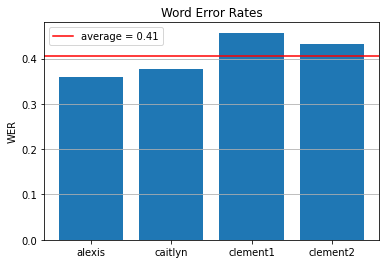

In [138]:
import matplotlib as pyplot

names = []
wer = []

for name in error_mesures:
    names.append(name)
    wer.append(error_mesures[name]["wer"])
mean_wer = np.mean(wer)

plt.bar(names,wer)
plt.axhline(mean_wer, color="red", label="average = " + str(mean_wer.round(2)))
plt.grid(axis='y')
plt.ylabel("WER")
plt.title("Word Error Rates")
plt.legend()

The WER is around 0.4 which is not so good. When we read the text, we notice indeed that there are still too many errors to really understand what is being said.

In comparison, for the "common voice" corpus the vosk model is claimed to have a wer of 0.16. This can be explained by the fact that in our corpus we have spontaneous speech instead of text that is read which is the case of the "common voice" corpus.